## Overview

### Rationale
I was quite unhappy with the machine learning part of breast_cancer_proteosome_analysis. Especially considering 'basal-lie', 'HER2', 'LumA', 'LumB' are quite different, I should be able to seperate these four cancer types apart.
In the previous notebook, I only used 2 models: K-neighbors and svm.SVC. However, I didn't explore all the way to finetune the models to get better performance.

One key step in real-world machine learning is about **extracting the correct feature sets**. It is a combination of application of domain knowledge and statistical analysis. In the breast_cancer_proteosome_analysis, I directly chose the PAM50 genes as the feature sets. Here, I will explore the 'statistical way' to extract features using scikit learn
**sklearn.feature_selection**. Notice here I didn't try feature union here, which is pretty handy most of the time. (I tried, the performance is not getting better.)

Another key point is utilizing **pipeline**. Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated. The goal is to ensure that all of the steps in the pipeline are constrained to the data available for the evaluation. This is actually pretty important

### Outline
1. Prep data
2. Feature Extraction
3. Pipeline & Gridsearch

### Result
The performance that we get is much better than the previous model.

In [138]:
# import the modules that are needed.
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Prepare the data
Most of the data prep part was done in 'breast_cancer_proteosome_analysis'.

In [2]:
merge = pd.read_csv('merge_proteome_clinic.csv', index_col=0)

In [3]:
proteome = merge.ix[:, :12553]

In [4]:
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(proteome)
processed_proteome = imputer.transform(proteome)

In [116]:
X = processed_proteome

In [117]:
merge['PAM50 mRNA'] = merge['PAM50 mRNA'].astype('category')
merge['PAM50_mRNA_label'] = merge['PAM50 mRNA'].cat.codes

In [118]:
y = merge['PAM50_mRNA_label'].values

### Feature Extraction
Scikit learn provides a pretty nice module called feature_selection to do this statistically.    
Personally, I don't really understand the details of the mechanism of different score_func.    
Here is a link of a blog by Jason Brownlee which talks about the feature selection for ML in python:    
http://machinelearningmastery.com/feature-selection-machine-learning-python/

In [126]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, f_regression
# feature extraction
test = SelectKBest(score_func=f_classif, k=185)
fit = test.fit(X, y)
# summarize scores
np.set_printoptions(precision=3)
features = fit.transform(X)

### SVM
Here I am just using grid search to find the best parameter sets of SVM.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(svm.SVC(), param_grid=param_grid)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### Pipeline & Gridsearch
Doing feature selection, (feature scaling), estimator together in a pipeline is the correct way to train a ML model.   
Here, I am using Pipeline to construct a process to extract the feature and SVM together.     
The performance is quite impressive considering the number of samples that we have.

In [130]:
feature = SelectKBest(score_func=f_classif)
clf = svm.SVC()
pipeline = make_pipeline(
                         feature,
                         clf)

params_grid = {'selectkbest__k': [10, 20, 30, 40, 50, 100, 150],
               'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
               'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]    
             }

grid = GridSearchCV(pipeline,
                    param_grid = params_grid,
                    cv = 3)

grid.fit(X_train, y_train)
print('The final score of the grid object is', grid.score(X_test, y_test))

The final score of the grid object is 0.85


In [131]:
# print out the model at the end
grid.estimator

Pipeline(steps=[('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x1146a6268>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Notice in the previous studies, they conclude that PAM50 proteome data can only tell apart 'Basal-like', 'HER2' and 'LumA/B' apart. However, here, with only **10 key features**, I am able to differentiate 4 types much better than prevous research.

Confusion matrix, without normalization
[[5 0 0 0]
 [0 3 0 0]
 [1 0 4 0]
 [0 0 2 5]]


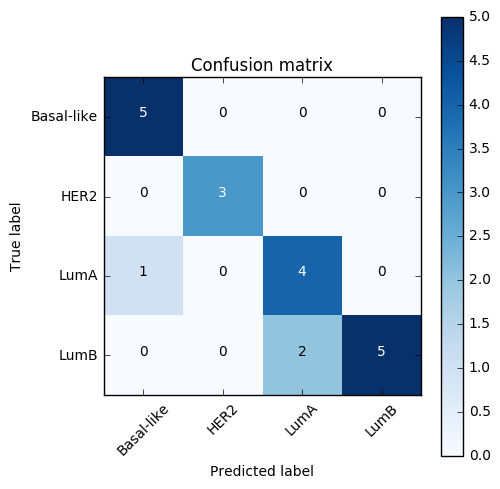

In [141]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(grid.predict(X_test), y_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(5,5))   
plot_confusion_matrix(cnf_matrix, classes=['Basal-like', 'HER2', 'LumA', 'LumB'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [157]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, grid.predict(X_test), average=None)
classes=['Basal-like', 'HER2', 'LumA', 'LumB']
f1_result = dict(zip(classes, f1))
print('F1 score summary', f1_result)

F1 score summary {'LumB': 0.83333333333333326, 'HER2': 1.0, 'LumA': 0.72727272727272718, 'Basal-like': 0.90909090909090906}
